<a href="https://colab.research.google.com/github/KhayKhun/cv_exercises/blob/main/myExercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from imutils.perspective import four_point_transform

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
def show_images(titles, images, wait=True):
    """Display multiple images with one line of code"""

    for (title, image) in zip(titles, images):
        plt.title(title)
        plt.imshow(image)
        plt.axis("off")
        plt.show()

    if wait:
        cv2.waitKey(0)
        cv2.destroyAllWindows()

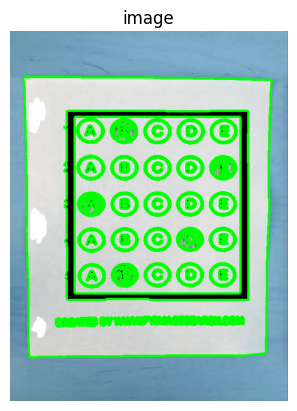

In [57]:
height = 800
width = 600
green = (0, 255, 0) # green color
red = (0, 0, 255) # red color
white = (255, 255, 255) # white color
questions = 5
answers = 5
correct_ans = [1, 4, 0, 3, 1]

img = cv2.imread('/content/hw2.jpg')
img = cv2.resize(img, (width, height))
img_copy = img.copy() # for display purposes
img_copy1 = img.copy() # for display purposes

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
edge_img = cv2.Canny(blur_img, 20, 200) # adjust with your images

# find the contours in the image
contours, _ = cv2.findContours(edge_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# draw the contours
cv2.drawContours(img, contours, -1, green, 3)
show_images(['image'], [img]) # helper function in helper.py file

In [58]:
def get_rect_cnts(contours):
    rect_cnts = []
    for cnt in contours:
        # approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        # if the approximated contour is a rectangle ...
        if len(approx) == 4:
            # append it to our list
            rect_cnts.append(approx)
    # sort the contours from biggest to smallest
    rect_cnts = sorted(rect_cnts, key=cv2.contourArea, reverse=True)

    return rect_cnts

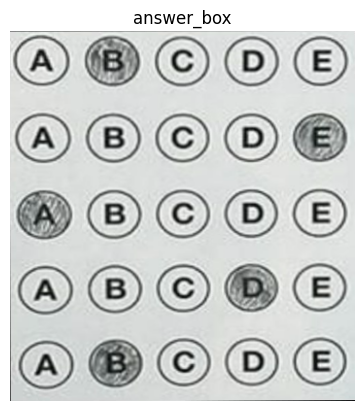

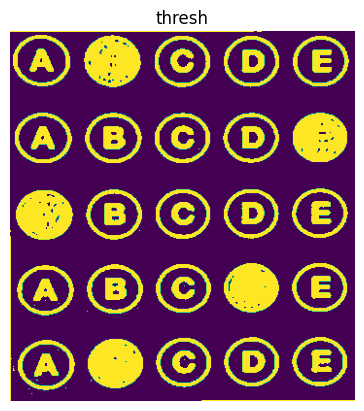

In [59]:
rect_cnts = get_rect_cnts(contours)


paper = four_point_transform(img_copy, rect_cnts[1].reshape(4, 2))
answer_box = four_point_transform(img_copy, rect_cnts[3].reshape(4, 2))

paper_copy = paper.copy()  # for display purposes
paper_copy1 = paper.copy() # for display purposes

cv2.drawContours(img_copy, rect_cnts, -1, green, 3)
# helper function in helper.py file

gray = cv2.cvtColor(answer_box, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

show_images(['answer_box', 'thresh'], [answer_box, thresh])

In [60]:
x, y = answer_box[0][0][0] +4 , answer_box[0][0][1] + 4
x_W, y_H = answer_box[2][0][0] - 4, answer_box[2][0][1] - 4

In [61]:
########################################################################
# Split the Area of the Biggest Contour
########################################################################

# split the thresholded image into boxes
def split_image(image):
    # make the number of rows and columns
    # a multiple of 5 (questions = answers = 5)
    r = len(image) // questions * questions
    c = len(image[0]) // answers * answers
    image = image[:r, :c]
    # split the image horizontally (row-wise)
    rows = np.vsplit(image, questions)
    boxes = []
    for row in rows:
        # split each row vertically (column-wise)
        cols = np.hsplit(row, answers)
        for box in cols:
            boxes.append(box)
    return boxes

boxes = split_image(thresh)


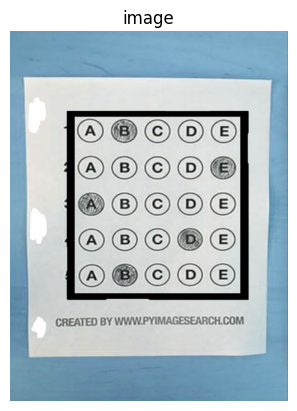

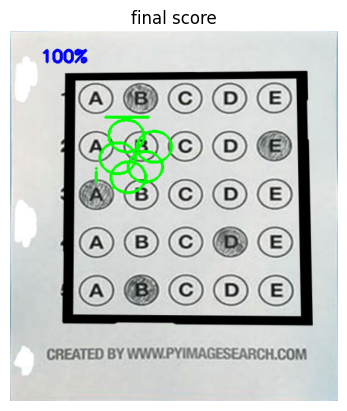

In [62]:
########################################################################
# Start Grading the Document
########################################################################

score = 0

# loop over the questions
for i in range(0, questions):
    user_answer = None

    # loop over the answers
    for j in range(answers):
        pixels = cv2.countNonZero(boxes[j + i * 5])
        # if the current answer has a larger number of
        # non-zero (white) pixels then the previous one
        # we update the `user_answer` variable
        if user_answer is None or pixels > user_answer[1]:
            user_answer = (j, pixels)

    # find the contours of the bubble that the user has filled
    cnt, _ = cv2.findContours(boxes[user_answer[0] + i * 5],
                                      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # translate the coordinates of the contours
    # to their original place in the document
    for c in cnt:
        c[:, :, 0] += x + ((x_W - x) // 5) * user_answer[0]
        c[:, :, 1] += y + ((y_H - y) // 5) * i


    # if the user's answer is correct, we increase the score and draw
    # a green contour arround the bubble that the user has filled
    if correct_ans[i] == user_answer[0]:
        cv2.drawContours(paper_copy1, cnt, -1, [0,255,0], 3)
        score += 1
    # otherwise we draw a red contour
    else:
        cv2.drawContours(paper_copy1, cnt, -1, [255,0,0], 3)

score = (score / 5) * 100
# get the (x, y) coordinates of the grade contour.
# we add some pixels to make sure the text is inside the contour.
x_grade = 50
y_grade = 50
cv2.putText(paper_copy1, "{}%".format(int(score)),
            (x_grade, y_grade), cv2.FONT_HERSHEY_SIMPLEX, 0.9, [0,0,255], 3)

show_images(['image', 'final score'], [img_copy1, paper_copy1])